$$
\text{This is the cutdown companion Jupyter notebook of Chapter 5, Variational Quantum Eigensolver (VQE) Algorithm, of the book titled:}$$
$$\text{ "Quantum Chemistry and Computing for the Curious: Illustrated with Python and Qiskit® code" and with ISBN-13: 978-1803243900.}$$

The following MIT license only applies to the code, and not to the text and images. The authors are not granting a license to replicate or reuse the text and images in the companion Jupyter notebook.

# MIT License

Copyright (c) 2022 Packt

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# 5. Variational Quantum Eigensolver (VQE) Algorithm


# Technical requirements

## Installing NumPy, and Qiskit and importing various modules
Install NumPy with the following command:

In [ ]:
pip install numpy

Install Qiskit with the following command:

In [ ]:
pip install qiskit

Install Qiskit visualization support with the following command:

In [ ]:
pip install 'qiskit[visualization]'

Install Qiskit Nature with the following command:

In [ ]:
pip install qiskit-nature

Install PySCF with the following command:

In [ ]:
pip install pyscf

Install QuTiP with the following command:

In [ ]:
pip install qutip

Install ASE with the following command:

In [ ]:
pip install ase

Install PyQMC with the following command:

In [ ]:
pip install pyqmc --upgrade

Install h5py with the following command:

In [ ]:
pip install h5py

Install SciPy with the following command:

In [ ]:
pip install scipy

Import NumPy with the following command:

In [ ]:
import numpy as np

Import Matplotlib, a comprehensive library for creating static, animated, and interactive visualizations in Python with the following command:



In [ ]:
import matplotlib.pyplot as plt

Import the required functions and class methods. The array_to_latex function() returns a Latex representation of a complex array with dimension 1 or 2:

In [ ]:
from qiskit.visualization import array_to_latex, plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere, plot_state_city
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit import execute, Aer
import qiskit.quantum_info as qi
from qiskit.extensions import Initialize
from qiskit.providers.aer import extensions  # import aer snapshot instructions

Import Qiskit Nature libraries with the following commands:








In [ ]:
from qiskit import Aer
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureDriverType, ElectronicStructureMoleculeDriver
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer, FreezeCoreTransformer
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.circuit.library.initial_states import HartreeFock
from qiskit_nature.circuit.library.ansatzes import UCCSD

Import the Qiskit Nature property framework with the following command:

In [ ]:
from qiskit_nature.properties import Property, GroupedProperty

Import the ElectronicEnergy property with the following command:

In [ ]:
# https://qiskit.org/documentation/nature/tutorials/08_property_framework.html
from qiskit_nature.properties.second_quantization.electronic import (
    ElectronicEnergy,
    ElectronicDipoleMoment,
    ParticleNumber,
    AngularMomentum,
    Magnetization,
)

Import the ElectronicIntegrals property with the following command:

In [ ]:
from qiskit_nature.properties.second_quantization.electronic.integrals import (
    ElectronicIntegrals,
    OneBodyElectronicIntegrals,
    TwoBodyElectronicIntegrals,
    IntegralProperty,
)
from qiskit_nature.properties.second_quantization.electronic.bases import ElectronicBasis

Import the Qiskit Aer statevector simulator and various algorithms with the following commands:

In [ ]:
from qiskit.providers.aer import StatevectorSimulator
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver, NumPyMinimumEigensolverFactory, BOPESSampler
from qiskit.algorithms import NumPyMinimumEigensolver, VQE, HamiltonianPhaseEstimation, PhaseEstimation
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import QNSPSA
from qiskit.opflow import StateFn, PauliExpectation,  CircuitSampler, PauliTrotterEvolution
from functools import partial as apply_variation

Import the PySCF gto and scf libraries with the following command:

In [ ]:
from pyscf import gto, scf

Import the PyQMC API library with the following command:

In [ ]:
import pyqmc.api as pyq

Import h5py with the following command:



In [ ]:
import h5py

Import the ASE libraries, the Atoms object, molecular data, and visualizations with the following commands:

In [ ]:
from ase import Atoms
from ase.build import molecule
from ase.visualize import view

Import the math libraries with the following commands:

In [ ]:
import cmath
import math

Import Python’s statistical functions provided by the SciPy package with the following command:

In [ ]:
import scipy.stats as stats

Import QuTiP with the following command:





In [ ]:
import qutip

Import time and datetime with the following command:

In [ ]:
import time, datetime

Import pandas and os.path with the following commands:

In [ ]:
import pandas as pd
import os.path

# 5.1. Variational method

## 5.1.2. Variational Monte Carlo methods

In [ ]:
def p(x):
  if x < 0:
    y = 0
  else:
    y = np.exp(-x)
  return(y)

In [ ]:
n = 10000 # Size of the Markov chain stationary distribution

# Use np.linspace to create an array of n numbers between 0 and n
index = np.linspace(0, n, num=n)
x = np.linspace(0, n, num=n)

x[0] = 3     # Initialize to 3
for i in range(1, n):
  current_x = x[i-1]

  # We add a N(0,1) random number to x
  proposed_x = current_x + stats.norm.rvs(loc=0, scale=1, size=1, random_state=None)

  A = min(1, p(proposed_x)/p(current_x))

  r = np.random.uniform(0,1) # Generate a uniform random number in [0, 1]

  if r < A:
    x[i] = proposed_x       # Accept move with probabilty min(1,A)
  else:
    x[i] = current_x        # Otherwise "reject" move, and stay where we are

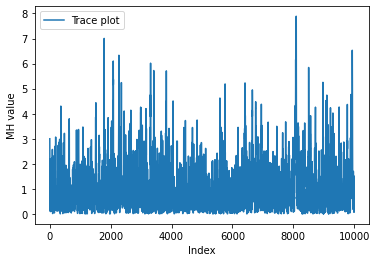

In [ ]:
plt.plot(index, x, label="Trace plot")
plt.xlabel('Index')
plt.ylabel('MH value')
plt.legend()
plt.show()

Figure 5.2 – Plot of the locations visited by the Markov chain  x

In [ ]:
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)

Freedman–Diaconis number of bins: 81


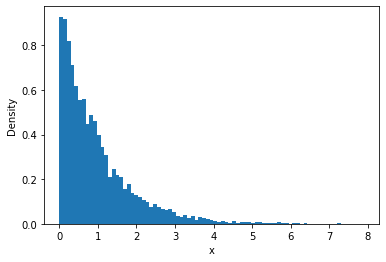

In [ ]:
plt.hist(x, density=True, bins=bins)
plt.ylabel('Density')
plt.xlabel('x');

Figure 5.3 – Histogram of the Markov chain  x

In [ ]:
def run_PySCF(molecule, pyqmc=True, show=True):
  # Reset the files
  for fname in ['mf.hdf5','optimized_wf.hdf5','vmc_data.hdf5','dmc.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
  
  mol_PySCF = gto.M(atom = [" ".join(map(str, (name, *coord))) for (name, coord) in molecule.geometry])
  
  mf = scf.RHF(mol_PySCF)
  mf.chkfile = "mf.hdf5"
  
  conv, e, mo_e, mo, mo_occ = scf.hf.kernel(mf)
  if show:
    if conv:
      print("PySCF restricted HF (RHF) converged ground-state energy: {:.12f}".format(e))
    else:
      print("PySCF restricted HF (RHF) ground-state computation failed to converge")

  if pyqmc:
    pyq.OPTIMIZE("mf.hdf5",# Construct a Slater-Jastrow wave function from the pyscf output
      "optimized_wf.hdf5", # Store optimized parameters in this file.
      nconfig=100,         # Optimize using this many Monte Carlo samples/configurations
      max_iterations=4,    # 4 optimization steps
      verbose=False)

    with h5py.File("optimized_wf.hdf5") as f:
      iter = f['iteration']
      energy = f['energy']
      error = f['energy_error']
      l = energy.shape[0]
      e = energy[l-1]
      err = error[l-1]
      if show:
        if err < 0.1:
          print("Iteration, Energy, Error")
          for k in iter:
            print("{}:         {:.4f} {:.4f}".format(k, energy[k], error[k]))
          print("PyQMC Monte Carlo converged ground-state energy: {:.12f}, error: {:.4f}".format(e, err))
        else:
          print("PyQMC Monte Carlo failed to converge")

  return conv, e

## 5.1.3. Quantum Phase Estimation (QPE)

In [ ]:
def U(theta):
  unitary = QuantumCircuit(1)
  unitary.p(np.pi*2*theta, 0)
  return unitary

In [ ]:
def do_qpe(unitary, nqubits=3, show=True):
  state_in = QuantumCircuit(1)
  state_in.x(0)
  pe = PhaseEstimation(num_evaluation_qubits=nqubits, quantum_instance=quantum_instance)
  result = pe.estimate(unitary, state_in)
  phase_out = result.phase
  if show:
    print("Number of qubits: {}, QPE phase estimate: {}".format(nqubits, phase_out))
  return(phase_out)

In [ ]:
quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))
theta = 1/2 + 1/4 + 1/8
print("theta: {}".format(theta))
unitary = U(theta)
result = do_qpe(unitary, nqubits=3)

theta: 0.875
Number of qubits: 3, QPE phase estimate: 0.875


In [ ]:
theta = 1/2 + 1/4 + 1/8 + 1/16 + 1/32 + 1/64 + 1/128 + 1/256
print("theta: {}".format(theta))
unitary = U(theta)
result = do_qpe(unitary, nqubits=8)

theta: 0.99609375
Number of qubits: 8, QPE phase estimate: 0.99609375


## 5.1.4. Description of the VQE algorithm

### Trial wavefunctions

### Setting-up the VQE solver


In [ ]:
quantum_instance = QuantumInstance(backend = Aer.get_backend('aer_simulator_statevector'))

In [ ]:
numpy_solver = NumPyMinimumEigensolver()

In [ ]:
tl_circuit = TwoLocal(rotation_blocks = ['h', 'rx'], entanglement_blocks = 'cz',
                      entanglement='full', reps=2, parameter_prefix = 'y')

In [ ]:
vqe_tl_solver = VQE(ansatz = tl_circuit,
                     quantum_instance = QuantumInstance(Aer.get_backend('aer_simulator_statevector')))

In [ ]:
vqe_ucc_solver = VQEUCCFactory(quantum_instance, ansatz=tl_circuit)

In [ ]:
qnspsa_loss = []
def qnspsa_callback(nfev, x, fx, stepsize, accepted):
    qnspsa_loss.append(fx)

# 5.2. Example chemical calculations

In [ ]:
def get_particle_number(problem, show=True):
  particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
  num_particles = (particle_number.num_alpha, particle_number.num_beta)
  num_spin_orbitals = particle_number.num_spin_orbitals
  if show:
    print("Number of alpha electrons: {}".format(particle_number.num_alpha))
    print("Number of beta electrons: {}".format(particle_number.num_beta))
    print("Number of spin orbitals: {}".format(num_spin_orbitals))
  return particle_number

In [ ]:
def fermion_to_qubit(f_op, second_q_op, mapper, truncate=20, two_qubit_reduction=False, z2symmetry_reduction=None, show=True): 
  if show:
    print("Qubit Hamiltonian operator")
  dmap = {"Jordan-Wigner": JordanWignerMapper(), "Parity": ParityMapper(), "Bravyi-Kitaev": BravyiKitaevMapper()}
  qubit_op = None
  qubit_converter = None
  for k, v in dmap.items():
    if k == mapper:
      if show:
        print("{} transformation ". format(mapper))
      qubit_converter = QubitConverter(v, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction)
      if two_qubit_reduction:
        qubit_op = qubit_converter.convert(second_q_op[0], num_particles=f_op.num_particles)
      else:
        qubit_op = qubit_converter.convert(second_q_op[0])
      n_items = len(qubit_op)
      if show:
        print("Number of items in the Pauli list:", n_items)
        if n_items <= truncate:
          print(qubit_op)
        else:
          print(qubit_op[0:truncate])
  return qubit_op, qubit_converter

In [ ]:
def run_vqe(name, f_op, qubit_converter, solver, show=True):
  calc = GroundStateEigensolver(qubit_converter, solver)
  start = time.time()
  ground_state = calc.solve(f_op)
  elapsed = str(datetime.timedelta(seconds = time.time()-start))
  if show:
    print("Running the VQE using the {}".format(name))
    print("Elapsed time: {} \n".format(elapsed))
    print(ground_state)
  return ground_state

In [ ]:
def run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=3, num_time_slices = 1, show=True):
  initial_state = HartreeFock(particle_number.num_spin_orbitals, 
                            (particle_number.num_alpha, 
                             particle_number.num_beta), qubit_converter)
  
  state_preparation = StateFn(initial_state)

  evolution = PauliTrotterEvolution('trotter', reps=num_time_slices)

  qpe = HamiltonianPhaseEstimation(n_ancillae, quantum_instance=quantum_instance)
  result = qpe.estimate(qubit_op, state_preparation, evolution=evolution)

  if show:
    print("\nQPE initial Hartree Fock state")
    display(initial_state.draw(output='mpl'))
    eigv = result.most_likely_eigenvalue
    print("QPE computed electronic ground state energy (Hartree): {}".format(eigv))
  
  return eigv

In [ ]:
def plot_energy_landscape(energy_surface_result):
  if len(energy_surface_result.points) > 1:
      plt.plot(energy_surface_result.points, energy_surface_result.energies, label="VQE Energy")
      plt.xlabel('Atomic distance Deviation(Angstrom)')
      plt.ylabel('Energy (hartree)')
      plt.legend()
      plt.show()
  else:
      print("Total Energy is: ", energy_surface_result.energies[0], "hartree")
      print("(No need to plot, only one configuration calculated.)")
  return

In [ ]:
def plot_loss(loss, label, target):
  plt.figure(figsize=(12, 6))
  plt.plot(loss, 'tab:green', ls='--', label=label)
  plt.axhline(target, c='tab:red', ls='--', label='target')
  plt.ylabel('loss')
  plt.xlabel('iterations')
  plt.legend()

In [ ]:
def solve_ground_state(
    molecule,
    mapper ="Parity",
    num_electrons=None,
    num_molecular_orbitals=None,
    transformers=None,
    two_qubit_reduction=False,
    z2symmetry_reduction = "Auto",
    name_solver='NumPy exact solver',
    solver=NumPyMinimumEigensolver(),
    plot_bopes=False,
    perturbation_steps=np.linspace(-1, 1, 3),
    pyqmc=True,
    n_ancillae=3, 
    num_time_slices=1,
    loss=[],
    label=None,
    target=None,
    show=True
):

    # Defining the electronic structure molecule driver
    driver = ElectronicStructureMoleculeDriver(molecule, basis='sto3g', driver_type=ElectronicStructureDriverType.PYSCF)

    # Splitting into classical and quantum
    if num_electrons != None and num_molecular_orbitals != None:
      split = ActiveSpaceTransformer(num_electrons=num_electrons, num_molecular_orbitals=num_molecular_orbitals)
    else:
      split = None

    # Defining a fermionic Hamiltonian operator
    if split != None:
      fermionic_hamiltonian = ElectronicStructureProblem(driver, [split])
    elif transformers != None:
      fermionic_hamiltonian = ElectronicStructureProblem(driver, transformers=transformers)
    else:
      fermionic_hamiltonian = ElectronicStructureProblem(driver)

    # Use the second_q_ops() method [Qiskit_Nat_3] which returns a list of second quantized operators
    second_q_op = fermionic_hamiltonian.second_q_ops()

    # Get particle number
    particle_number = get_particle_number(fermionic_hamiltonian, show=show)

    if show:
      # We set truncation to 1000 with the method set_truncation(1000)
      second_q_op[0].set_truncation(1000)
      # then we print the first 20 terms of the fermionic Hamiltonian operator of the molecule
      print("Fermionic Hamiltonian operator")
      print(second_q_op[0])
    
    # Use the function fermion_to_qubit() to convert a fermionic operator to a qubit operator
    if show:
      print(" ")
    qubit_op, qubit_converter = fermion_to_qubit(fermionic_hamiltonian, second_q_op, mapper=mapper, two_qubit_reduction=two_qubit_reduction, z2symmetry_reduction=z2symmetry_reduction, show=show)

    # Run the the PySCF RHF method
    if show:
      print(" ")
    conv, e = run_PySCF(molecule, pyqmc=pyqmc, show=show)

    # Run QPE
    eigv = run_qpe(particle_number, qubit_converter, qubit_op, n_ancillae=n_ancillae, num_time_slices=num_time_slices, show=show)

    # Run VQE
    if show:
      print(" ")
    ground_state = run_vqe(name_solver, fermionic_hamiltonian, qubit_converter, solver, show=show)

    # Plot loss function
    if loss != []:
      plot_loss(loss, label, target)

    if plot_bopes:
      # Compute the potential energy surface as follows:
      energy_surface = BOPESSampler(gss=GroundStateEigensolver(qubit_converter, solver), bootstrap=False)
      # Fix enables using BOPESS together with Unitary Coupled Cluster (UCC) factory ansatz
      # Set default to an empty dictionary instead of None:
      energy_surface._points_optparams = {}
      energy_surface_result = energy_surface.sample(fermionic_hamiltonian, perturbation_steps)

      # Plot the energy as a function of atomic separation
      plot_energy_landscape(energy_surface_result)

    return fermionic_hamiltonian, particle_number, qubit_op, qubit_converter, ground_state

## 5.2.1. Hydrogen molecule

In [ ]:
hydrogen_molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)

### Varying the hydrogen molecule

In [ ]:
molecular_variation = Molecule.absolute_stretching

In [ ]:
specific_molecular_variation = apply_variation(molecular_variation, atom_pair=(1, 0))

In [ ]:
hydrogen_molecule_stretchable = Molecule(geometry=
                                 [['H', [0., 0., 0.]],
                                  ['H', [0., 0., 0.735]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])

### Solving for the Ground-state

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3 )
+ (-0.47189600728114245+0j) * ( +_3 -_3 )
+ (-1.2563390730032498+0j) * ( +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.47189600728114245+0j) * ( +_1 -_1 )
+ (0.6985737227320175+0j) * ( +_1 -_1 +_3 -_3 )
+ (0.6645817302552965+0j) * ( +_1 -_1 +_2 -_2 )
+ (-1.2563390730032498+0j) * ( +_0 -_0 )
+ (0.6645817302552965+0j) * ( +_0 -_0 +_3 -_3 )
+ (0.6757101548035161+0j) * ( +_0 -_0 +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_0 -_0 +_1 -_1 )
 
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
0.18093119978423114 * XX
- 1.0523732457728605 * II
- 0.39793742484317884 * ZI
+ 0.39793742

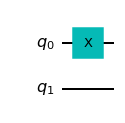

QPE computed electronic ground state energy (Hartree): -1.7934378610679784
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:00:00.458114 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [ ]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(hydrogen_molecule, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'NumPy exact solver', solver = numpy_solver)

Figure 5.5. Ground-state of the $\text{H}_{2}$ molecule with PySCF RHF and PyQMC Monte Carlo

Figure 5.6. Ground-state of the $\text{H}_{2}$ molecule computed with VQE using the NumPy minimum eigensolver

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3 )
+ (-0.47189600728114245+0j) * ( +_3 -_3 )
+ (-1.2563390730032498+0j) * ( +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.47189600728114245+0j) * ( +_1 -_1 )
+ (0.6985737227320175+0j) * ( +_1 -_1 +_3 -_3 )
+ (0.6645817302552965+0j) * ( +_1 -_1 +_2 -_2 )
+ (-1.2563390730032498+0j) * ( +_0 -_0 )
+ (0.6645817302552965+0j) * ( +_0 -_0 +_3 -_3 )
+ (0.6757101548035161+0j) * ( +_0 -_0 +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_0 -_0 +_1 -_1 )
 
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
0.18093119978423114 * XX
- 1.0523732457728605 * II
- 0.39793742484317884 * ZI
+ 0.39793742

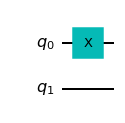

QPE computed electronic ground state energy (Hartree): -1.7934378610679784
 
Running the VQE using the Unitary Coupled Cluster (UCC) factory ansatz
Elapsed time: 0:00:00.733471 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275022649
  - computed part:      -1.857275022649
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.1373060282
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [ ]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(hydrogen_molecule, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'Unitary Coupled Cluster (UCC) factory ansatz', solver = vqe_ucc_solver)

Figure 5.7. Ground-state of the $\text{H}_{2}$ molecule with VQE using the UCC factory ansatz.

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3 )
+ (-0.47189600728114245+0j) * ( +_3 -_3 )
+ (-1.2563390730032498+0j) * ( +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.47189600728114245+0j) * ( +_1 -_1 )
+ (0.6985737227320175+0j) * ( +_1 -_1 +_3 -_3 )
+ (0.6645817302552965+0j) * ( +_1 -_1 +_2 -_2 )
+ (-1.2563390730032498+0j) * ( +_0 -_0 )
+ (0.6645817302552965+0j) * ( +_0 -_0 +_3 -_3 )
+ (0.6757101548035161+0j) * ( +_0 -_0 +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_0 -_0 +_1 -_1 )
 
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
0.18093119978423114 * XX
- 1.0523732457728605 * II
- 0.39793742484317884 * ZI
+ 0.39793742

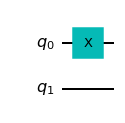

QPE computed electronic ground state energy (Hartree): -1.7934378610679784
 
Running the VQE using the Heuristic ansatz, the Two-Local circuit with SLSQP
Elapsed time: 0:00:00.631273 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275004599
  - computed part:      -1.857275004599
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.13730601015
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [ ]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(hydrogen_molecule, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'Heuristic ansatz, the Two-Local circuit with SLSQP',solver = vqe_tl_solver)

Figure 5.8. Ground-state of the $\text{H}_{2}$ molecule with VQE using the Two-Local circuit and SLSQP

In [ ]:
qnspsa_loss = []
ansatz = tl_circuit
fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=200, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)

In [ ]:
vqe_tl_QNSPSA_solver = VQE(ansatz=tl_circuit, optimizer=qnspsa,
                     quantum_instance=quantum_instance)

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3 )
+ (-0.47189600728114245+0j) * ( +_3 -_3 )
+ (-1.2563390730032498+0j) * ( +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.47189600728114245+0j) * ( +_1 -_1 )
+ (0.6985737227320175+0j) * ( +_1 -_1 +_3 -_3 )
+ (0.6645817302552965+0j) * ( +_1 -_1 +_2 -_2 )
+ (-1.2563390730032498+0j) * ( +_0 -_0 )
+ (0.6645817302552965+0j) * ( +_0 -_0 +_3 -_3 )
+ (0.6757101548035161+0j) * ( +_0 -_0 +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_0 -_0 +_1 -_1 )
 
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
0.18093119978423114 * XX
- 1.0523732457728605 * II
- 0.39793742484317884 * ZI
+ 0.39793742

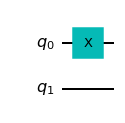

QPE computed electronic ground state energy (Hartree): -1.7934378610679784
 
Running the VQE using the Two-Local circuit and the QN-SPSA optimizer
Elapsed time: 0:00:03.928984 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.85726198942
  - computed part:      -1.85726198942
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137292994971
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


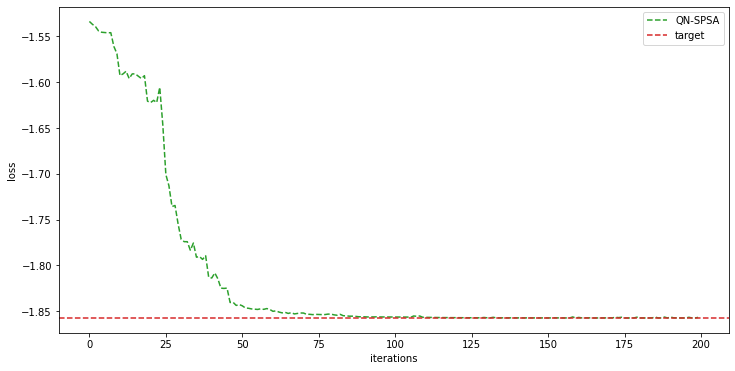

In [ ]:
H2_fermionic_hamiltonian, H2_particle_number, H2_qubit_op, H2_qubit_converter, H2_ground_state = \
                  solve_ground_state(hydrogen_molecule, mapper ="Parity",
                  two_qubit_reduction=True, z2symmetry_reduction=None, loss=qnspsa_loss, label='QN-SPSA', target=-1.857274810366,
                  name_solver='Two-Local circuit and the QN-SPSA optimizer', solver=vqe_tl_QNSPSA_solver)

Figure 5.9 – Ground-state of the $\text{H}_{2}$ molecule with VQE using the Two-Local circuit and QN-SPSA

Figure 5.10 – Plot of the loss function of the VQE using the Two-Local circuit and QN-SPSA for the $\text{H}_{2}$ molecule

### Computing the BOPES

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3 )
+ (-0.47189600728114245+0j) * ( +_3 -_3 )
+ (-1.2563390730032498+0j) * ( +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.47189600728114245+0j) * ( +_1 -_1 )
+ (0.6985737227320175+0j) * ( +_1 -_1 +_3 -_3 )
+ (0.6645817302552965+0j) * ( +_1 -_1 +_2 -_2 )
+ (-1.2563390730032498+0j) * ( +_0 -_0 )
+ (0.6645817302552965+0j) * ( +_0 -_0 +_3 -_3 )
+ (0.6757101548035161+0j) * ( +_0 -_0 +_2 -_2 )
+ (0.4836505304710653+0j) * ( +_0 -_0 +_1 -_1 )
 
Qubit Hamiltonian operator
Parity transformation 
Number of items in the Pauli list: 5
0.18093119978423114 * XX
- 1.0523732457728605 * II
- 0.39793742484317884 * ZI
+ 0.39793742

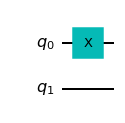

QPE computed electronic ground state energy (Hartree): -1.7934378610679784
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:00:00.441179 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


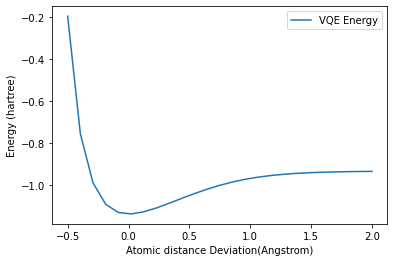

In [ ]:
perturbation_steps = np.linspace(-0.5, 2, 25) # 25 equally spaced points from -0.5 to 2, inclusive.
H2_stretchable_fermionic_hamiltonian, H2_stretchable_particle_number, H2_stretchable_qubit_op, H2_stretchable_qubit_converter, H2_stretchable_ground_state = \
                  solve_ground_state(hydrogen_molecule_stretchable, mapper ="Parity",
                   two_qubit_reduction=True, z2symmetry_reduction=None, 
                   name_solver = 'NumPy exact solver', solver = numpy_solver,
                   plot_bopes = True, perturbation_steps=perturbation_steps)

Figure 5.12 – Plot of the BOPES of the hydrogen molecule

## 5.2.2. Lithium hydride molecule

In [ ]:
LiH_molecule = Molecule(geometry=[['Li', [0., 0., 0.]],
                              ['H', [0., 0., 1.5474]]],
                     charge=0, multiplicity=1)

### Varying the lithium hydride molecule

In [ ]:
LiH_molecule_stretchable = Molecule(geometry=[['Li', [0., 0., 0.]],
                              ['H', [0., 0., 1.5474]]],
                    charge=0, multiplicity=1,
                    degrees_of_freedom=[specific_molecular_variation])

### Solving for the Ground-state

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 6
Fermionic Hamiltonian operator
Fermionic Operator
register length=6, number terms=117
  (0.012557929501996105+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.03399663387923222+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.012557929501996086+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.03399663387923224+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.008886443232579824+0j) * ( +_0 -_1 +_4 -_5 )
+ (-0.00888644323257985+0j) * ( +_0 -_1 -_4 +_5 )
+ (0.04770212338466273+0j) * ( +_0 -_1 )
+ (-0.0427274251317337+0j) * ( +_0 -_1 +_5 -_5 )
+ (0.00678985984955151+0j) * ( +_0 -_1 +_4 -_4 )
+ (-0.047702117137939704+0j) * ( +_0 -_1 +_3 -_3 )
+ (-0.011291412068144484+0j) * ( +_0 -_1 +_2 -_2 )
+ (-0.03399663387923222+0j) * ( +_0 -_2 +_3 -_4 )
+ (0.123384387853094+0j) * ( +_0 -_2 +_3 -_5 )
+ (0.033996633879232255+0j) * ( +_0 -_2 -_3 +_4 )
+ (-0.12338438785309398+0j) * ( +_0 -_2 -_3 +_5 )
+ (-0.03143601306358916+0j) * ( +_0 -_2 +_4 -_5 )
+ (0.031436013063589216+0j) * ( +_0 -_2 -_

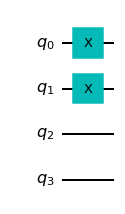

QPE computed electronic ground state energy (Hartree): -0.9611256062362894
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:00:01.308928 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


In [ ]:
LiH_fermionic_hamiltonian, LiH_particle_number, LiH_qubit_op, LiH_qubit_converter, LiH_ground_state = \
                  solve_ground_state(LiH_molecule, mapper="Parity",
                  transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])],
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver='NumPy exact solver', solver=numpy_solver)

Figure 5.13 – Ground-state of the $\text{LiH}$ molecule with PySCF RHF, PyQMC Monte Carlo and QPE

Figure 5.14. Ground-state of the $\text{LiH}$ molecule with VQE using the NumPy minimum eigensolver

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 6
Fermionic Hamiltonian operator
Fermionic Operator
register length=6, number terms=117
  (0.012557929502021302+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.03399663387926378+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.012557929502021309+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.0339966338792638+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.008886443232607948+0j) * ( +_0 -_1 +_4 -_5 )
+ (-0.008886443232607937+0j) * ( +_0 -_1 -_4 +_5 )
+ (0.047702123384755345+0j) * ( +_0 -_1 )
+ (-0.042727425131781266+0j) * ( +_0 -_1 +_5 -_5 )
+ (0.006789859849570571+0j) * ( +_0 -_1 +_4 -_4 )
+ (-0.04770211713799643+0j) * ( +_0 -_1 +_3 -_3 )
+ (-0.011291412068168114+0j) * ( +_0 -_1 +_2 -_2 )
+ (-0.03399663387926378+0j) * ( +_0 -_2 +_3 -_4 )
+ (0.12338438785307912+0j) * ( +_0 -_2 +_3 -_5 )
+ (0.03399663387926377+0j) * ( +_0 -_2 -_3 +_4 )
+ (-0.12338438785307931+0j) * ( +_0 -_2 -_3 +_5 )
+ (-0.03143601306361302+0j) * ( +_0 -_2 +_4 -_5 )
+ (0.03143601306361315+0j) * ( +_0 -_2

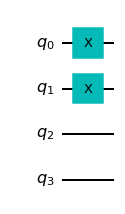

QPE computed electronic ground state energy (Hartree): -0.9611256062363783
 
Running the VQE using the Heuristic ansatz, the Two-Local circuit with SLSQP
Elapsed time: 0:00:02.280446 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.889048172829
  - computed part:      -1.070357877248
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.863113293186
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.83091067]
    - computed part:      [0.0  0.0  4.83485753]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.90674846]  Total: 1.90674846
                 (debye): [0.0  0.0  -4.84647072]  Total: 4.84647072
 


In [ ]:
LiH_fermionic_hamiltonian, LiH_particle_number, LiH_qubit_op, LiH_qubit_converter, LiH_ground_state = \
                  solve_ground_state(LiH_molecule, mapper="Parity",
                  transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])],
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver = 'Heuristic ansatz, the Two-Local circuit with SLSQP', solver = vqe_tl_solver)

Figure 5.15 – Ground-state of the $\text{LiH}$ molecule with VQE using the Two-Local circuit and SLSQP

In [ ]:
qnspsa_loss = []
ansatz = tl_circuit
fidelity = QNSPSA.get_fidelity(ansatz, quantum_instance, expectation=PauliExpectation())
qnspsa = QNSPSA(fidelity, maxiter=500, learning_rate=0.01, perturbation=0.7, callback=qnspsa_callback)

In [ ]:
vqe_tl_QNSPSA_solver = VQE(ansatz=tl_circuit, optimizer=qnspsa,
                     quantum_instance=quantum_instance)

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 6
Fermionic Hamiltonian operator
Fermionic Operator
register length=6, number terms=117
  (0.012557929501996105+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.03399663387923222+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.012557929501996086+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.03399663387923224+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.008886443232579824+0j) * ( +_0 -_1 +_4 -_5 )
+ (-0.00888644323257985+0j) * ( +_0 -_1 -_4 +_5 )
+ (0.04770212338466273+0j) * ( +_0 -_1 )
+ (-0.0427274251317337+0j) * ( +_0 -_1 +_5 -_5 )
+ (0.00678985984955151+0j) * ( +_0 -_1 +_4 -_4 )
+ (-0.047702117137939704+0j) * ( +_0 -_1 +_3 -_3 )
+ (-0.011291412068144484+0j) * ( +_0 -_1 +_2 -_2 )
+ (-0.03399663387923222+0j) * ( +_0 -_2 +_3 -_4 )
+ (0.123384387853094+0j) * ( +_0 -_2 +_3 -_5 )
+ (0.033996633879232255+0j) * ( +_0 -_2 -_3 +_4 )
+ (-0.12338438785309398+0j) * ( +_0 -_2 -_3 +_5 )
+ (-0.03143601306358916+0j) * ( +_0 -_2 +_4 -_5 )
+ (0.031436013063589216+0j) * ( +_0 -_2 -_

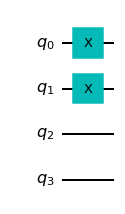

QPE computed electronic ground state energy (Hartree): -0.9611256062362894
 
Running the VQE using the Two-Local circuit and the QN-SPSA optimizer
Elapsed time: 0:00:14.126321 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.887383712179
  - computed part:      -1.068693416598
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.861448832535
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.019 S^2: 0.020 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.77191467]
    - computed part:      [0.0  0.0  4.77586153]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.84775246]  Total: 1.84775246
                 (debye): [0.0  0.0  -4.69651785]  Total: 4.69651785
 


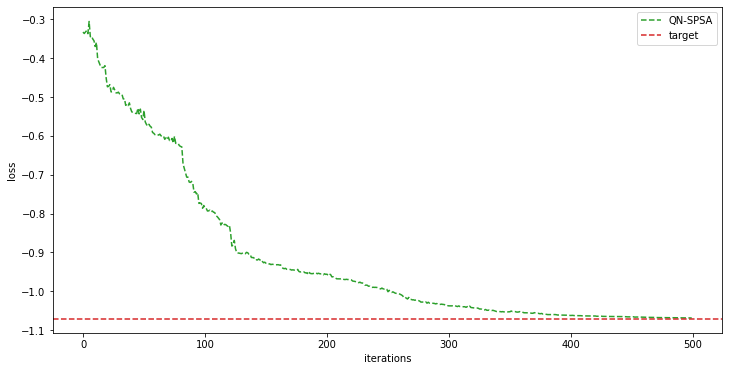

In [ ]:
LiH_fermionic_hamiltonian, LiH_particle_number, LiH_qubit_op, LiH_qubit_converter, LiH_ground_state = \
                  solve_ground_state(LiH_molecule, mapper="Parity",
                  transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])],
                  two_qubit_reduction=True, z2symmetry_reduction="auto", loss=qnspsa_loss, label='QN-SPSA', target=-1.0703584,
                  name_solver='Two-Local circuit and the QN-SPSA optimizer', solver=vqe_tl_QNSPSA_solver)

Figure 5.16 – Ground-state of the $\text{LiH}$ molecule with VQE using the Two-Local circuit and QN-SPSA

Figure 5.17 – Loss function of the VQE using the Two-Local circuit and QN-SPSA for the $\text{LiH}$ molecule

### Computing the BOPES


Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 6
Fermionic Hamiltonian operator
Fermionic Operator
register length=6, number terms=117
  (0.012557929501996105+0j) * ( +_0 -_1 +_3 -_4 )
+ (-0.03399663387923222+0j) * ( +_0 -_1 +_3 -_5 )
+ (-0.012557929501996086+0j) * ( +_0 -_1 -_3 +_4 )
+ (0.03399663387923224+0j) * ( +_0 -_1 -_3 +_5 )
+ (0.008886443232579824+0j) * ( +_0 -_1 +_4 -_5 )
+ (-0.00888644323257985+0j) * ( +_0 -_1 -_4 +_5 )
+ (0.04770212338466273+0j) * ( +_0 -_1 )
+ (-0.0427274251317337+0j) * ( +_0 -_1 +_5 -_5 )
+ (0.00678985984955151+0j) * ( +_0 -_1 +_4 -_4 )
+ (-0.047702117137939704+0j) * ( +_0 -_1 +_3 -_3 )
+ (-0.011291412068144484+0j) * ( +_0 -_1 +_2 -_2 )
+ (-0.03399663387923222+0j) * ( +_0 -_2 +_3 -_4 )
+ (0.123384387853094+0j) * ( +_0 -_2 +_3 -_5 )
+ (0.033996633879232255+0j) * ( +_0 -_2 -_3 +_4 )
+ (-0.12338438785309398+0j) * ( +_0 -_2 -_3 +_5 )
+ (-0.03143601306358916+0j) * ( +_0 -_2 +_4 -_5 )
+ (0.031436013063589216+0j) * ( +_0 -_2 -_

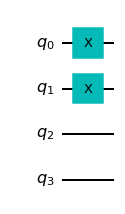

QPE computed electronic ground state energy (Hartree): -0.9611256062362894
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:00:01.321389 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -8.907396311316
  - computed part:      -1.088706015735
  - FreezeCoreTransformer extracted energy part: -7.818690295581
~ Nuclear repulsion energy (Hartree): 1.025934879643
> Total ground state energy (Hartree): -7.881461431673
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  2.92416221]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  4.76300889]
    - computed part:      [0.0  0.0  4.76695575]
    - FreezeCoreTransformer extracted energy part: [0.0  0.0  -0.00394686]
  > Dipole moment (a.u.): [0.0  0.0  -1.83884668]  Total: 1.83884668
                 (debye): [0.0  0.0  -4.67388163]  Total: 4.67388163
 


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


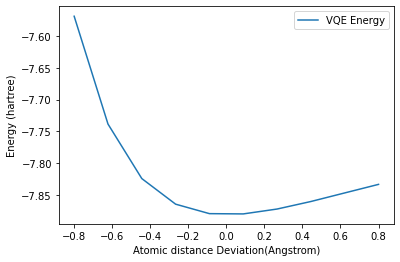

In [ ]:
perturbation_steps = np.linspace(-0.8, 0.8, 10) # 10 equally spaced points from -0.8 to 0.8, inclusive.
LiH_stretchable_fermionic_hamiltonian, LiH_stretchable_particle_number, LiH_stretchable_qubit_op, LiH_stretchable_qubit_converter, LiH_stretchable_ground_state = \
                  solve_ground_state(LiH_molecule_stretchable, mapper ="Parity",
                  transformers=[FreezeCoreTransformer(freeze_core=True, remove_orbitals=[4, 3])],
                   two_qubit_reduction=True, z2symmetry_reduction="auto", 
                   name_solver='NumPy exact solver', solver=numpy_solver,
                   plot_bopes=True, perturbation_steps=perturbation_steps)

Figure 5.19 – Plot of the Born-Oppenheimer Potential Energy Surface (BOPES) of the $\text{LiH}$ molecule

## 5.2.3. Macro molecule


In [ ]:
macro_ASE = Atoms('ONCHHHC', [(1.1280, 0.2091, 0.0000), 
                          (-1.1878, 0.1791, 0.0000), 
                          (0.0598, -0.3882, 0.0000),
                          (-1.3085, 1.1864, 0.0001),
                          (-2.0305, -0.3861, -0.0001),
                          (-0.0014, -1.4883, -0.0001),
                          (-0.1805, 1.3955, 0.0000)])

In [ ]:
view(macro_ASE, viewer='x3d')

Figure 5.20 – Macro molecule

In [ ]:
molecular_variation = Molecule.absolute_stretching

In [ ]:
specific_molecular_variation = apply_variation(molecular_variation, atom_pair=(6, 1))

In [ ]:
macromolecule = Molecule(geometry=
                                 [['O', [1.1280, 0.2091, 0.0000]],
                                  ['N', [-1.1878, 0.1791, 0.0000]],
                                  ['C', [0.0598, -0.3882, 0.0000]],
                                  ['H', [-1.3085, 1.1864, 0.0001]],
                                  ['H', [-2.0305, -0.3861, -0.0001]],
                                  ['H', [-0.0014, -1.4883, -0.0001]],
                                  ['C', [-0.1805, 1.3955, 0.0000]]],
                                  charge=0, multiplicity=1,
                                  degrees_of_freedom=[specific_molecular_variation])

### Solving for the Ground-state

In [ ]:
print("Macro molecule")
print("Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits")
print("Parameters ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)")
print("Setting z2symmetry_reduction=\"auto\"")

Macro molecule
Using the ParityMapper with two_qubit_reduction=True to eliminate two qubits
Parameters ActiveSpaceTransformer(num_electrons=2, num_molecular_orbitals=2)
Setting z2symmetry_reduction="auto"


Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=26
  (0.026919512277769175+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.02691951227776917+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.05107681606888003+0j) * ( +_0 -_1 )
+ (-0.04926855566987212+0j) * ( +_0 -_1 +_3 -_3 )
+ (0.05107674503956358+0j) * ( +_0 -_1 +_2 -_2 )
+ (-0.02691951227776917+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.02691951227776918+0j) * ( -_0 +_1 -_2 +_3 )
+ (0.05107681606887988+0j) * ( -_0 +_1 )
+ (0.04926855566987205+0j) * ( -_0 +_1 +_3 -_3 )
+ (-0.05107674503956364+0j) * ( -_0 +_1 +_2 -_2 )
+ (-0.05107681606888003+0j) * ( +_2 -_3 )
+ (0.05107681606887988+0j) * ( -_2 +_3 )
+ (-0.32719041369212737+0j) * ( +_3 -_3 )
+ (-0.7480534066333778+0j) * ( +_2 -_2 )
+ (0.2759517326970386+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.04926855566987212+0j) * ( +_1 -_1 +_2 -_3 )
+ (0.04926855566987205+0j) * ( +_1 -_1 -_2 +_3 )
+ (-0.32719041369212737+0j) * ( +_1 -_

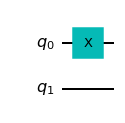

QPE computed electronic ground state energy (Hartree): -0.8244072113871437
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:46:45.446393 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -318.206223981746
  - computed part:      -0.885465166125
  - ActiveSpaceTransformer extracted energy part: -317.320758815622
~ Nuclear repulsion energy (Hartree): 114.661165852466
> Total ground state energy (Hartree): -203.545058129281
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-6.34040909  15.65127868  -0.00018897]
 
  0: 
  * Electronic dipole moment (a.u.): [-5.12026581  16.91295797  -0.00024077]
    - computed part:      [-0.70824787  4.63305797  -0.00017904]
    - ActiveSpaceTransformer extracted energy part: [-4.41201795  12.2799  -0.00006172]
  > Dipole moment (a.u.): [-1.22014328  -1.26167929  0.0000518]  Total: 1.75515933
                 (debye): [-

In [ ]:
macro_fermionic_hamiltonian, macro_particle_number, macro_qubit_op, macro_qubit_converter, macro_ground_state = \
                  solve_ground_state(macromolecule, mapper="Parity",
                  num_electrons=2, num_molecular_orbitals=2,
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver='NumPy exact solver', solver=numpy_solver, pyqmc=False)

Figure 5.21 – First 20 terms of the fermionic Hamiltonian operator of the macro molecule

Figure 5.22 – Qubit Hamiltonian operator of the outermost two electrons of the macro molecule

Figure 5.23 – Total and electronic ground state energy of the macro molecule by PySCF and QPE respectively

Figure 5.24 – Ground state of macro molecule using the NumPy exact minimum eigensolver

### Computing the BOPES

Number of alpha electrons: 1
Number of beta electrons: 1
Number of spin orbitals: 4
Fermionic Hamiltonian operator
Fermionic Operator
register length=4, number terms=26
  (0.026919512277768027+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.02691951227776802+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.0510768160688799+0j) * ( +_0 -_1 )
+ (-0.04926855566987122+0j) * ( +_0 -_1 +_3 -_3 )
+ (0.051076745039562686+0j) * ( +_0 -_1 +_2 -_2 )
+ (-0.02691951227776802+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.02691951227776801+0j) * ( -_0 +_1 -_2 +_3 )
+ (0.05107681606888+0j) * ( -_0 +_1 )
+ (0.04926855566987115+0j) * ( -_0 +_1 +_3 -_3 )
+ (-0.05107674503956274+0j) * ( -_0 +_1 +_2 -_2 )
+ (-0.0510768160688799+0j) * ( +_2 -_3 )
+ (0.05107681606888+0j) * ( -_2 +_3 )
+ (-0.32719041369212176+0j) * ( +_3 -_3 )
+ (-0.748053406633378+0j) * ( +_2 -_2 )
+ (0.27595173269703793+0j) * ( +_2 -_2 +_3 -_3 )
+ (-0.04926855566987122+0j) * ( +_1 -_1 +_2 -_3 )
+ (0.04926855566987115+0j) * ( +_1 -_1 -_2 +_3 )
+ (-0.32719041369212176+0j) * ( +_1 -_1 )
+ (

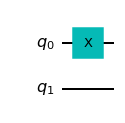

QPE computed electronic ground state energy (Hartree): -0.8244072113871395
 
Running the VQE using the NumPy exact solver
Elapsed time: 0:39:37.044129 

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -318.206223981747
  - computed part:      -0.885465166125
  - ActiveSpaceTransformer extracted energy part: -317.320758815622
~ Nuclear repulsion energy (Hartree): 114.661165852466
> Total ground state energy (Hartree): -203.545058129281
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-6.34040909  15.65127868  -0.00018897]
 
  0: 
  * Electronic dipole moment (a.u.): [-5.12026581  16.91295797  -0.00024077]
    - computed part:      [-0.70824787  4.63305797  -0.00017904]
    - ActiveSpaceTransformer extracted energy part: [-4.41201795  12.2799  -0.00006172]
  > Dipole moment (a.u.): [-1.22014328  -1.26167929  0.0000518]  Total: 1.75515933
                 (debye): [-

In [ ]:
perturbation_steps = np.linspace(-0.5, 3, 10) # 10 equally spaced points from -0.5 to 3, inclusive.
macro_fermionic_hamiltonian, macro_particle_number, macro_qubit_op, macro_qubit_converter, macro_ground_state = \
                  solve_ground_state(macromolecule, mapper ="Parity",
                  num_electrons=2, num_molecular_orbitals=2,
                  two_qubit_reduction=True, z2symmetry_reduction="auto", 
                  name_solver='NumPy exact solver', solver=numpy_solver, pyqmc=False,
                  plot_bopes=True, perturbation_steps=perturbation_steps)

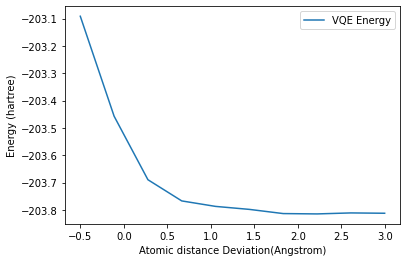

Figure 5.25 – Plot of the Born-Oppenheimer Potential Energy Surface (BOPES) of the macro molecule

# Summary


# Questions

1.   Does the variational theorem apply to excited states?


In [ ]:
#@title Enter your answer Yes, No or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "Yes"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

2. True or False: The Metropolis-Hastings method is a way to approximate integration over spatial coordinates.

In [ ]:
#@title Enter your answer True, False or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "True"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

3. True or False: VQE is only a quantum computing algorithm and does not require the use of classical computing.

In [ ]:
#@title Enter your answer True, False or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "False"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")

4. Can UCCSD be mapped to qubits?

In [ ]:
#@title Enter your answer Yes, No or ? for a solution, then execute cell.
answer = "" #@param {type:"string"}
solution = "Yes"
if answer == solution:
  print("Correct")
elif answer == '?':
  print(solution)
else:
  print("Incorrect, please try again")